# factorization machines スクラッチ

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sys; sys.path.append('..')
from util.time import stop_watch
%matplotlib inline

In [2]:
class FM:
    def __init__(
        self, 
        epochs=50, 
        n_factors=3, 
        learning_rate=1e-6,
        random_seed=1234
    ):
        self.epochs = epochs
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.random_seed = random_seed
    
    @stop_watch
    def fit(self, X, y) -> None:
        
        self.n_samples, self.n_features = X.shape
        self.w0 = 0.0
        self.wi = np.zeros(self.n_features)
        
        np.random.seed(self.random_seed)
        self.V = np.random.normal(
            scale=1/np.sqrt(self.n_factors),
            size=(self.n_factors, self.n_features)
        )
        
        self.losses = []
        for _ in range(self.epochs):
        
            y_hat = self.predict(X)
            loss = np.sqrt(mean_squared_error(y, y_hat))
            self.losses.append(loss)
            error = y - y_hat
            
            for column_index in range(self.n_samples):
                
                e_i =  error[column_index]
                
                # update w0
                self.w0 += 2*self.learning_rate*e_i
                
                # update wi
                for feature in range(self.n_features):
                    wi_grad = X[column_index,feature]
                    self.wi[feature] += 2*self.learning_rate*e_i*wi_grad
                
                # update V
                for factor in range(self.n_factors):
                    for feature in range(self.n_features):
                        term = self.V[factor,:]@X[column_index,:]
                        V_grad = X[column_index, feature]*term - self.V[factor, feature]*(X[column_index, feature]**2)
                        
                        self.V[factor, feature] += 2*self.learning_rate*e_i*V_grad
                                    
    def predict(self, X):
        
        # 2項目
        linear_out = X@self.wi
        
        #３項目
        factor_out = np.array([
            0.5*np.sum(np.array([(self.V[factor,:]@X[column_index,:])**2 - (self.V[factor,:]**2)@(X[column_index,:]**2) 
                                 for factor in range(self.n_factors)])) 
            for column_index in range(self.n_samples)
        ])

        return self.w0 + linear_out + factor_out 
        
    
    def predict_instance(self, x):
        
        # 2項目
        linear_out = x@self.wi
        
        # 3項目
        factor_out = 0.5*np.sum(np.array([(self.V[factor,:]@x)**2 - (self.V[factor,:]**2)@(x**2) for factor in range(self.n_factors)]))
        
        return self.w0 + linear_out + factor_out
        
    
    def plot_train_curve(self, ylim_min=0.0, ylim_max=6.0):
        plt.subplots(1, figsize=(8,6))
        plt.plot(np.arange(len(self.losses)), self.losses, label="Train RMSE", linewidth=3)
   
        plt.title("Train Curves", fontdict=dict(size=20))
        plt.xlabel("Number of Epochs", fontdict=dict(size=20))
        plt.ylabel("Root Mean Squared Error", fontdict=dict(size=20))
        plt.ylim([ylim_min, ylim_max])
        plt.tight_layout()
        plt.legend(loc="best", fontsize=20)
        plt.show()
        

In [3]:
import pandas as pd

rating_df = pd.read_csv("../data/movielens/train_rating.csv")

In [4]:
rating_df = rating_df.sort_values('timestamp', ascending=False)
rating_df = rating_df.iloc[0:100]

In [5]:
ratings = rating_df["rating"].values
rating_df = rating_df[["user_id","movie_id"]]

In [6]:
features = rating_df.values
features = OneHotEncoder().fit_transform(features).toarray()

fitの処理時間:　4.62秒


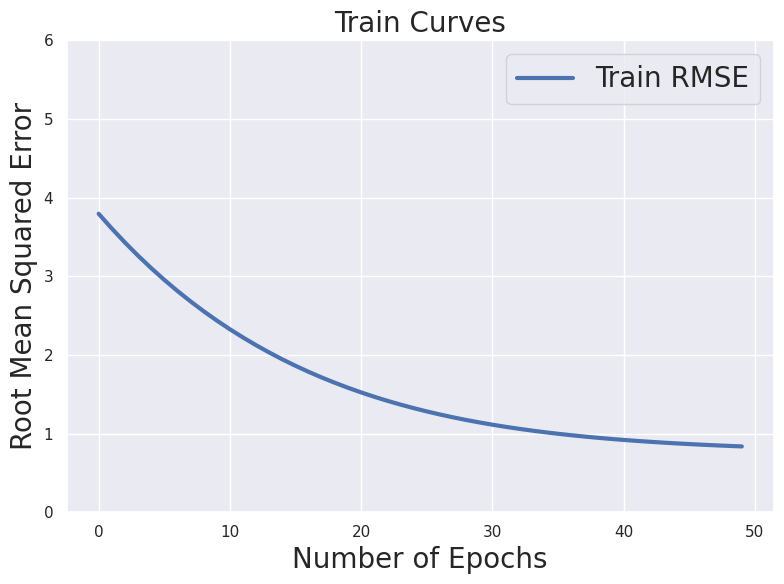

In [7]:
model = FM(learning_rate=2e-4)
model.fit(features, ratings)
model.plot_train_curve()

In [8]:
index = 2
y_hat = model.predict_instance(features[index])
print(f"y = {ratings[index]}, y^ = {y_hat:.2f}")

y = 3.5, y^ = 2.90


## 第三項目の交互作用項の計算, O(D^2)かO(kD)の比較

In [9]:
from time import time

In [12]:
start = time()

X = features
linear_out = X@model.wi
factor_out = []
for column_index in range(model.n_samples):
    pred = 0
    for i in range(model.n_features):
        for j in range(i+1, model.n_features):
            pred += model.V[:,i].dot(model.V[:,j])*X[column_index,i]*X[column_index,j]
    factor_out.append(pred)
        
y_hat = model.w0 + linear_out + np.array(factor_out) 

stop = time()
print(f"計算時間：　{stop-start:.2f}")

計算時間：　0.50


In [13]:
start = time()

X = features
linear_out = X@model.wi
factor_out = np.array([
    0.5*np.sum(np.array([(model.V[factor,:]@X[column_index,:])**2 - (model.V[factor,:]**2)@(X[column_index,:]**2) 
                         for factor in range(model.n_factors)])) 
    for column_index in range(model.n_samples)
])

y_hat = model.w0 + linear_out + factor_out 

stop = time()
print(f"計算時間：　{stop-start:.2f}")

計算時間：　0.00
